In [165]:
import json
import pandas as pd

# Path to your NDJSON file
file_path = "swipes.ndjson"

# Read the NDJSON file into a DataFrame
df = pd.read_json(file_path, lines=True, encoding="utf-16")

In [166]:
df = df.drop(columns=["username"])

In [167]:
len(df["swipe"][0])

1

In [168]:
# removes any datapoints that are only one point
df = df[df['swipe'].apply(lambda x: isinstance(x, list) and len(x) != 1)]

In [169]:
# Create new columns for x, y, and t as lists
df['x'] = df['swipe'].apply(lambda swipe: [point[0] for point in swipe])
df['y'] = df['swipe'].apply(lambda swipe: [point[1] for point in swipe])
df['t'] = df['swipe'].apply(lambda swipe: [point[2] for point in swipe])

In [170]:
df["t"] = df["t"].apply(lambda x: [t - x[0] for t in x])

In [171]:
import numpy as np

flattened_x = np.concatenate(df['x'].values)
flattened_y = np.concatenate(df['y'].values)
max_abs_value = max(np.max(np.abs(flattened_x)), np.max(np.abs(flattened_y)))

In [172]:
def process_coordinate(list):
    first = list[0]
    return np.array([(t - first)/max_abs_value for t in list])

In [173]:
df["x_scaled"] = df["x"].apply(process_coordinate)
df["y_scaled"] = df["y"].apply(process_coordinate)

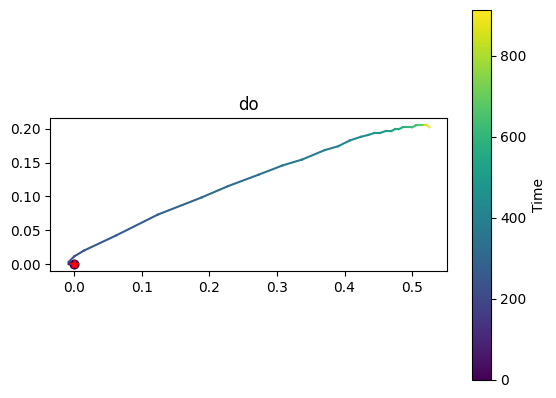

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
i = 9
x = np.array(df["x_scaled"][i])
y = np.array(df["y_scaled"][i]) * -1
time = np.array(df["t"][i])

# Normalize the time values for the colormap
norm = plt.Normalize(min(time), max(time))
colors = plt.cm.viridis(norm(time))  # Use a colormap (e.g., 'viridis')

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each segment with a color based on time
for j in range(len(x) - 1):
    ax.plot(x[j:j+2], y[j:j+2], color=colors[j], marker='o' if j == 0 else None)

# Highlight the starting point
ax.plot(x[0], y[0], "r*")
ax.set_title(df["word"][i])
ax.set_aspect('equal', adjustable='box')
# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Add a colorbar for reference
cbar = plt.colorbar(sm, ax=ax, label='Time')

plt.show()

In [175]:
type(df["x_scaled"][1])

numpy.ndarray

In [176]:
i = 9
x = df["x_scaled"][i]
y = df["y_scaled"][i]
t = df["t"][i]

dx = np.diff(x)
dy = np.diff(y)
dt = np.diff(t)

distance = np.sqrt(dx**2 + dy**2)

speed = distance/dt  # in units per ms
# Pad speed (forward difference, pad with first value)
padded_speed = np.concatenate(([speed[0]], speed))

dv = np.diff(padded_speed)
acceleration = dv/dt

padded_acceleration = np.concatenate(([acceleration[0]], acceleration))

angles = np.arctan2(dy,dx)
padded_angles = np.concatenate((angles, [angles[-1]]))


In [177]:
def calculate_v_a_r(x, y, t):
    # calculates the speed in units/ms, acceleration in units/ms/ms and approach from previous point between -pi and pi
    dx = np.diff(x)
    dy = np.diff(y)
    dt = np.diff(t)

    distance = np.sqrt(dx**2 + dy**2)
    speed = distance / dt  # in units/ms
    padded_speed = np.concatenate(([speed[0]], speed))

    dv = np.diff(padded_speed)
    acceleration = dv / dt  # in units/ms
    padded_acceleration = np.concatenate(([acceleration[0]], acceleration))

    angles = np.arctan2(dy, dx)  # in radians
    padded_angles = np.concatenate(([angles[0]], angles))

    return pd.Series([padded_speed, padded_acceleration, padded_angles])

In [178]:
df[["velocity", "acceleration", "angles"]] = df.apply(lambda row: calculate_v_a_r(row['x_scaled'], row['y_scaled'], row['t']), axis=1)

In [187]:
def collate_input(x_coord, y_coord, time, speed, accel, angle):
    return [[x, y, t, v, a, r] for x, y, t, v, a, r in zip(x_coord, y_coord, time, speed, accel, angle)]

In [190]:
df["input"] = df.apply(lambda row: collate_input(row['x_scaled'], row['y_scaled'], row['t'], row["velocity"], row["acceleration"], row["angles"]), axis=1)

Inputs

- X, Y : scaled by absolute max of x and y with the starting point being (0,0)
- time : time of touchpoint from the beginnning of the gesture
- speed: instantaneous speed in units/ms
- acceleration: accleration in units/ms/ms
- angles: approach angle from the previous point in radians from -$\pi$ to $\pi$

Targets

- Convert the target word into a sequence
- Each letter is then tokenised
- Mapped to a vocabulary

_ is a blank character used for CTC loss

In [193]:
vocabulary = {'_': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8,
              'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16,
              'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24,
              'y': 25, 'z': 26}

In [197]:
def process_target(word):
    word = word.lower()
    return [vocabulary[char] for char in word]

In [201]:
df["target"] = df["word"].apply(process_target)